In [46]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
image_size = (250, 260)
batch_size = 10

train_datagen=ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

test_datagen = ImageDataGenerator(
                               rotation_range=30,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.8, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5]) #included in our dependencies

training_data_dir = r'D:\amsokol\Development\tensorflow-build\test - Copy'
validation_data_dir = r'D:\amsokol\Development\tensorflow-build\test - Copy - Copy'

train_generator=train_datagen.flow_from_directory(training_data_dir,
                                                 target_size=image_size,
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 class_mode='categorical',
                                                 shuffle=True)

validation_generator = test_datagen.flow_from_directory(
                                        validation_data_dir,
                                         target_size=image_size,
                                         color_mode='rgb',
                                        class_mode = "categorical")

Found 674 images belonging to 3 classes.
Found 767 images belonging to 3 classes.


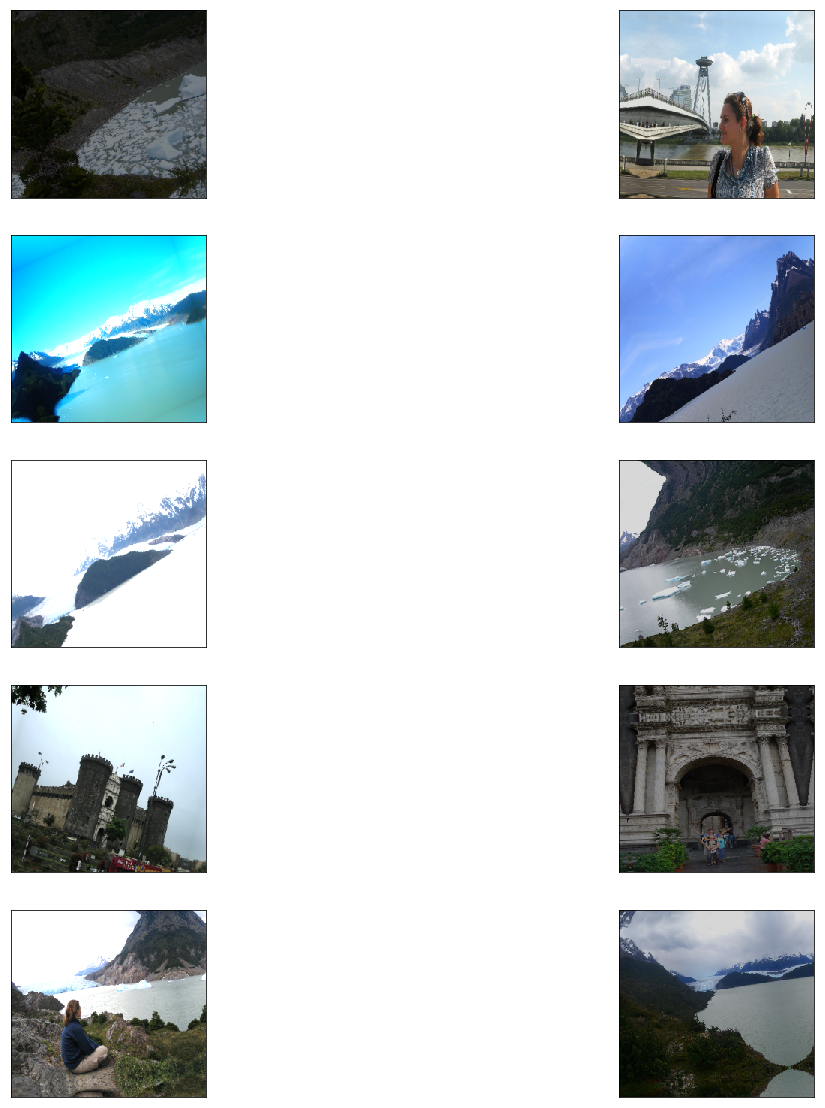

In [47]:
x_batch, y_batch = next(train_generator)
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 20))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = x_batch[i]
    image= image.astype(int)
    plt.imshow(image)

In [48]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

In [49]:
base_model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_size[0], image_size[1], 3))


In [50]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 250, 260, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 260, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 260, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 130, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 130, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 130, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 65, 128)       0         
__________

In [51]:
for layer in base_model.layers[:17]:
    layer.trainable = False

In [52]:
from tensorflow.keras import regularizers

classCount = 3

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(classCount,activation='softmax', activity_regularizer=regularizers.l2(0.01))(x) #final layer with softmax activation

model_final=Model(inputs=base_model.input,outputs=preds)

In [53]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 250, 260, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 260, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 260, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 130, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 130, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 130, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 65, 128)       0         
__________

In [54]:
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [55]:

step_size_train=train_generator.n//train_generator.batch_size
print(step_size_train)

67


In [65]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
import tensorflow
import os

history11 = []
history12 = []
history21 = []
history22 = []
class TrainValTensorBoard(TensorBoard):
    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        
        for name, value in logs.items():     
            if name.startswith('val_'):
                if name.endswith("loss"):
                    history11.append(value.item())
                elif name.endswith("acc"):
                    history12.append(value.item())
            else:
                if name.endswith("loss"):
                    history21.append(value.item())
                elif name.endswith("acc"):
                    history22.append(value.item())

In [66]:
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=2, verbose=1, mode='auto')

import time

networkfileName = "vgg16_{}.h5".format(int(time.time()))
checkpoint = ModelCheckpoint(networkfileName, monitor='val_acc', verbose=1,
                             save_best_only=True, save_weights_only=False, mode='auto', period=1)

In [67]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

model_final.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator,
                   epochs=5
                   ,callbacks = [TrainValTensorBoard(write_graph=False), checkpoint, early])

Epoch 1/5
66/67 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9970
Epoch 00001: val_acc improved from -inf to 0.98566, saving model to vgg16_1546629706.h5
67/67 [==============================] - 41s 614ms/step - loss: 0.1129 - acc: 0.9970 - val_loss: 0.3541 - val_acc: 0.9857
Epoch 2/5
66/67 [============================>.] - ETA: 0s - loss: 0.1130 - acc: 0.9970
Epoch 00002: val_acc improved from 0.98566 to 0.99087, saving model to vgg16_1546629706.h5
67/67 [==============================] - 42s 623ms/step - loss: 0.1128 - acc: 0.9970 - val_loss: 0.3418 - val_acc: 0.9909
Epoch 3/5
66/67 [============================>.] - ETA: 0s - loss: 0.1106 - acc: 0.9985
Epoch 00003: val_acc did not improve from 0.99087
67/67 [==============================] - 41s 608ms/step - loss: 0.1104 - acc: 0.9985 - val_loss: 0.3469 - val_acc: 0.9909
Epoch 4/5
66/67 [============================>.] - ETA: 0s - loss: 0.1082 - acc: 1.0000
Epoch 00004: val_acc improved from 0.99087 to 0.99348

In [68]:
print("Ima tomer")

Ima tomer


In [69]:
print(history11)
print(history21)


[0.35406235893981863, 0.3417664899586699, 0.3469251167354559, 0.3406320869378658, 0.3455587159623689]
[0.1135717158441443, 0.11340653573174074, 0.11102731290262148, 0.10866153529699309, 0.11019034305615212]


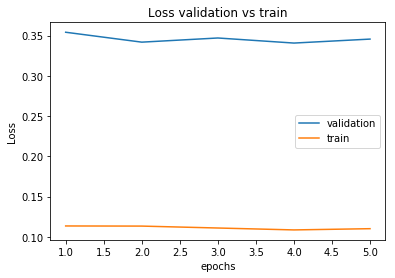

In [73]:
import matplotlib.pyplot as plt
x = range(1, len(history11) + 1)
plt.plot(x, history11)
plt.plot(x, history21)
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss validation vs train')
plt.legend(['validation', 'train'])

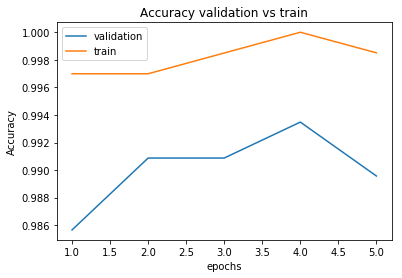

In [74]:
import matplotlib.pyplot as plt
x = range(1, len(history12) + 1)
plt.plot(x, history12)
plt.plot(x, history22)
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy validation vs train')
plt.legend(['validation', 'train'])